# Treinamento com o Torchsample

O objetivo deste notebook é treinar uma rede usando a metodologia de treinamento de alto nível oferecido pelo Torchsample.

## Importação das bibliotecas

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import torchsample

import matplotlib.pyplot as plt
import pandas as pd

## Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos 500 amostras de treinamento e 100 amostras de validação.

In [2]:
dataset = torchvision.datasets.MNIST('/data/datasets/MNIST/', train=True, download=True)
x_train, y_train = torch.load(os.path.join(dataset.root, 'processed/training.pt'))
x_test, y_test = torch.load(os.path.join(dataset.root, 'processed/test.pt'))

x_train = x_train.float()
y_train = y_train.long()
x_test = x_test.float()
y_test = y_test.long()

x_train = x_train / 255.
x_test = x_test / 255.
x_train = x_train.unsqueeze(1)
x_test = x_test.unsqueeze(1)

# only train on a subset
x_train = x_train[:1000]
y_train = y_train[:1000]
x_test = x_test[:500]
y_test = y_test[:500]

train_dataset = torchsample.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
val_dataset = torchsample.TensorDataset(x_test, y_test)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

print('Tamanho do dataset de treino:    ', len(train_dataset))
print('Tamanho do dataset de validação: ', len(val_dataset), end='\n\n')

print('Dimensões dos dados das imagens: ', train_dataset[0][0].size())
print('Tipo dos dados das imagens:      ', type(train_dataset[0][0]))
print('Tipo das classes das imagens:    ', type(train_dataset[0][1]), end='\n\n')

print('Amostras para treinamento:       ', len(train_dataset))
print('Amostras para validação:         ', len(val_dataset))

Tamanho do dataset de treino:     1000
Tamanho do dataset de validação:  500

Dimensões dos dados das imagens:  torch.Size([1, 28, 28])
Tipo dos dados das imagens:       <class 'torch.FloatTensor'>
Tipo das classes das imagens:     <class 'int'>

Amostras para treinamento:        1000
Amostras para validação:          500


## Visualizando os dados

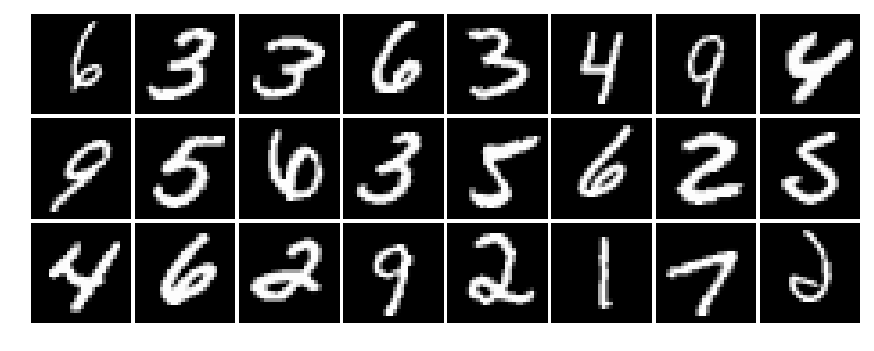

In [3]:
temp_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=24,
                                              shuffle=True)
image_batch, labels = next(iter(temp_dataloader))
grid = torchvision.utils.make_grid(image_batch, normalize=True, pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

## Criação da rede

In [4]:
# Define your model EXACTLY as if you were using nn.Module
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 1600)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
#         return F.log_softmax(x)
        return x

In [5]:
# Define your model EXACTLY as if you were using nn.Module
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Treinamento

In [6]:
model = Network()
trainer = torchsample.modules.ModuleTrainer(model)

callbacks = [torchsample.callbacks.EarlyStopping(patience=10),
             torchsample.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)]
regularizers = [torchsample.regularizers.L1Regularizer(scale=1e-3, module_filter='conv*'),
                torchsample.regularizers.L2Regularizer(scale=1e-5, module_filter='fc*')]
constraints = [torchsample.constraints.UnitNorm(frequency=3, unit='batch', module_filter='fc*')]
initializers = [torchsample.initializers.XavierUniform(bias=False, module_filter='fc*')]
metrics = [torchsample.metrics.CategoricalAccuracy(top_k=3)]

trainer.compile(loss=torch.nn.CrossEntropyLoss(),
#                 loss='nll_loss',
                optimizer='adadelta',
#                 optimizer=torch.optim.SGD(model.parameters(), lr=.5),
                regularizers=regularizers,
                constraints=constraints,
                initializers=initializers,
                metrics=metrics, 
                callbacks=callbacks,
               )

try:
    trainer.fit_loader(train_loader, val_loader, num_epoch=20, verbose=1)
except KeyboardInterrupt:
    print('-> trainer.fit_loader interrupted')

Epoch 1/20: : 33 batches [00:00, 250.26 batches/s, loss=0.581, reg_loss=0.00834, val_loss=0.987, val_acc=89.80, acc=80.20, lr=[1.0]]                
Epoch 2/20: : 33 batches [00:00, 193.56 batches/s, loss=0.222, reg_loss=0.00834, val_loss=0.68, val_acc=94.80, acc=94.30, lr=[1.0]]                
Epoch 3/20: : 33 batches [00:00, 253.56 batches/s, loss=0.145, reg_loss=0.00834, val_loss=0.56, val_acc=95.40, acc=96.60, lr=[1.0]]                
Epoch 4/20: : 33 batches [00:00, 201.89 batches/s, loss=0.0921, reg_loss=0.00834, val_loss=0.501, val_acc=97.20, acc=97.40, lr=[1.0]]                
Epoch 5/20: : 33 batches [00:00, 201.16 batches/s, loss=0.0766, reg_loss=0.00834, val_loss=0.467, val_acc=97.80, acc=98.20, lr=[1.0]]                
Epoch 6/20: : 33 batches [00:00, 267.04 batches/s, loss=0.0651, reg_loss=0.00834, val_loss=0.455, val_acc=97.40, acc=98.70, lr=[1.0]]                
Epoch 7/20: : 33 batches [00:00, 245.58 batches/s, loss=0.0527, reg_loss=0.00834, val_loss=0.444, val_acc

## Avaliando a acurácia tanto no conjunto de treinamento como no conjunto de validação

In [7]:
print('Training Accuracy:   {}%'.format(trainer.evaluate_loader(train_loader)['val_acc_metric']))
print('Validation Accuracy: {}%'.format(trainer.evaluate_loader(val_loader)['val_acc_metric']))

Training Accuracy:   100.0%
Validation Accuracy: 98.4%


## Matriz de confusão com dados de treinamento e validação

In [8]:
for title, ds in zip (['treinamento', 'validação'], [train_dataset, val_dataset]):
    _, pred = torch.max(F.softmax(trainer.predict(ds.inputs[0])), dim=1)
    pred = pred.data.numpy()
    targ = ds.targets[0].numpy()

    print('Matriz de confusão ({}): '.format(title))
    display(pd.crosstab(pred, targ))

Matriz de confusão (treinamento): 


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,97,0,0,0,0,0,0,0,0,0
1,0,116,0,0,0,0,0,0,0,0
2,0,0,99,0,0,0,0,0,0,0
3,0,0,0,93,0,0,0,0,0,0
4,0,0,0,0,105,0,0,0,0,0
5,0,0,0,0,0,92,0,0,0,0
6,0,0,0,0,0,0,94,0,0,0
7,0,0,0,0,0,0,0,117,0,0
8,0,0,0,0,0,0,0,0,87,0


Matriz de confusão (validação): 


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,41,0,0,0,0,0,1,0,1,0
1,0,67,0,0,0,0,0,0,0,0
2,0,0,48,2,0,1,1,0,2,0
3,1,0,2,33,0,1,0,0,0,0
4,0,0,0,0,46,1,0,2,1,1
5,0,0,0,6,0,41,2,0,1,1
6,0,0,1,0,4,1,38,0,0,0
7,0,0,2,4,0,3,1,45,2,5
8,0,0,1,0,0,0,0,0,30,0


# Broken tools:

In [9]:
# trainer history functionality removed
print(trainer.history)

{'loss': [], 'val_loss': [], 'reg_loss': []}


In [10]:
# predict_loader broken
trainer.predict_loader(train_loader)

TypeError: 'DataLoader' object is not an iterator